# Giving geospatial context to a dataset

This a short analysis to illustrate if adding the distance to an art galley, museum or other cultural center help improve a model to predict the price you pay per night for your Airbnb. The Airbnb dataset used for this exercise was downloaded from the website [Inside Airbnb](http://insideairbnb.com/) and the inventory of cultural sites was downloaded from [Seattle's Open Data Portal](https://data.seattle.gov/). Using these publicly accessible datasets we will show how to give some spatial context to a dataset while trying to answer the following questions:

1. Which are the most expensive neighborhoods in Seattle and what is their average distance to cultural sites?
2. Does the variable distance help create a more accurate predictive model?
3. Which are the most influential variables for predicting price per night?

## Data exploration

In [31]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [32]:
# Import the Airbnb dataset
listings = pd.read_csv('data/listings.csv')
# listings.head(3)

In [33]:
# Data cleaning
# drop all rows with nulls in columns ['price', 'latitude', 'longitude']
listings.dropna(subset=['price', 'latitude', 'longitude'], inplace=True)
# clean up 'price' column
tmp_price = listings['price'].str.split('$', expand=True)
listings['price_cleansed'] = tmp_price[1].str.replace(',', '').astype('float')

In [34]:
# Import the cultural sites dataset
cultural = pd.read_csv('data/Seattle_Cultural_Space_Inventory.csv')
# cultural.head(3)

In [35]:
# Data cleaning
# drop all rows with null in columns ['Latitude', 'Longitude']
cultural.dropna(subset=['Latitude', 'Longitude'], inplace=True)

## Create the geospatial variable

In [36]:
# Create geodataframes and reproject them to UTM Zone 10N
gpd_airbnb = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings.longitude, listings.latitude), crs='EPSG:4326').to_crs('EPSG:32610')
gpd_cultural = gpd.GeoDataFrame(cultural, geometry=gpd.points_from_xy(cultural.Longitude, cultural.Latitude), crs='EPSG:4326').to_crs('EPSG:32610')

In [37]:
# Join both geodataframes based on the closest cultural point
gpd_airbnb_cultural = gpd_airbnb.sjoin_nearest(gpd_cultural, distance_col="distance")
gpd_airbnb_cultural[['price_cleansed', 'distance']]

,price_cleansed,distance
0,85.0,510.173926
1,150.0,47.540641
3,100.0,262.710441
6,80.0,364.272624
9,150.0,224.897479
...,...,...
3793,109.0,504.657756
3732,65.0,347.697735
3733,125.0,65.873128
3781,55.0,183.272086


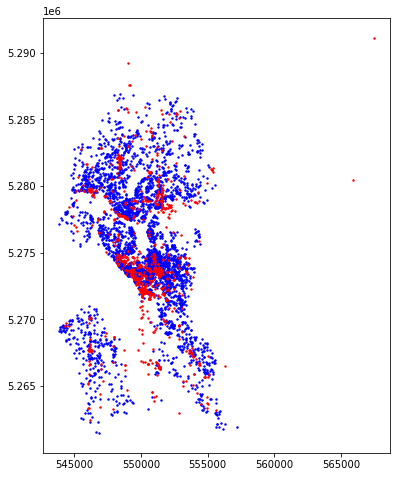

In [38]:
# Visualization
base = gpd_airbnb.plot(markersize=2, color="blue", figsize=(10,8))
gpd_cultural.plot(ax=base, markersize=2, color='red');

## Which are the most expensive neighborhoods in Seattle and what is their average distance to cultural sites?

Other neighborhoods    836
Capitol Hill           583
Downtown               563
Name: neighbourhood_group_cleansed, dtype: int64


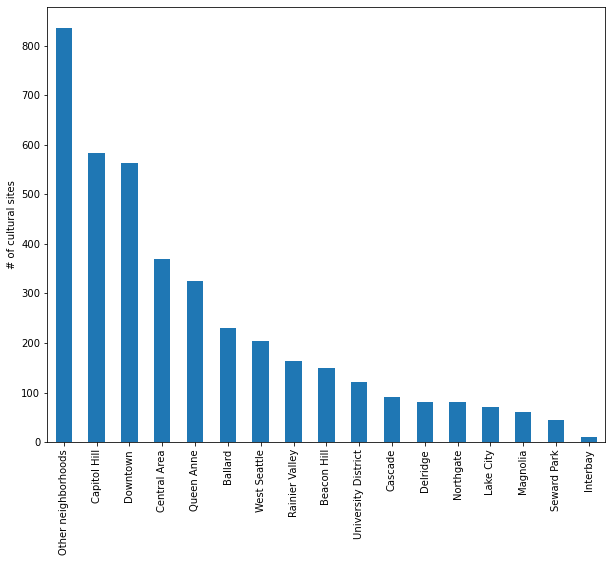

In [39]:
# Number of cultural sites by neighborhood
print(gpd_airbnb_cultural['neighbourhood_group_cleansed'].value_counts()[:3])
gpd_airbnb_cultural['neighbourhood_group_cleansed'].value_counts().plot.bar(figsize=(10,8), xlabel='', ylabel='# of cultural sites');

neighbourhood_group_cleansed
Magnolia      177.672131
Queen Anne    157.466258
Downtown      154.470693
Name: price_cleansed, dtype: float64


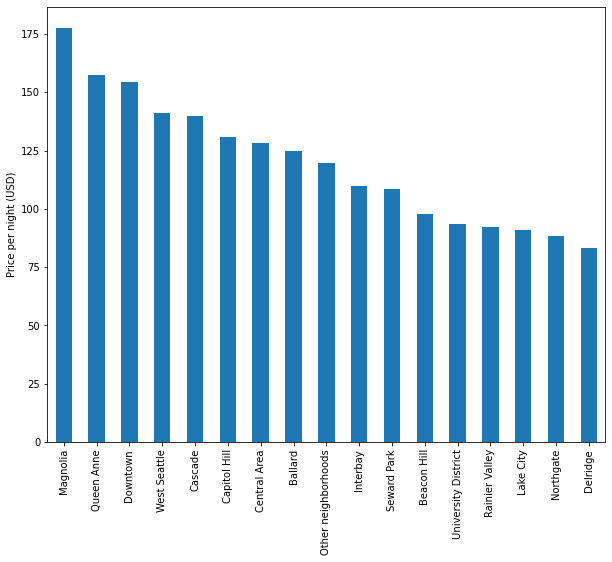

In [40]:
# Average price by neighbouthoob
print(gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['price_cleansed'].mean().sort_values(ascending=False)[:3])
gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['price_cleansed'].mean().sort_values(ascending=False).plot.bar(figsize=(10,8), xlabel='', ylabel='Price per night (USD)');

neighbourhood_group_cleansed
Downtown                94.266945
University District    153.061736
Capitol Hill           216.085600
Name: distance, dtype: float64


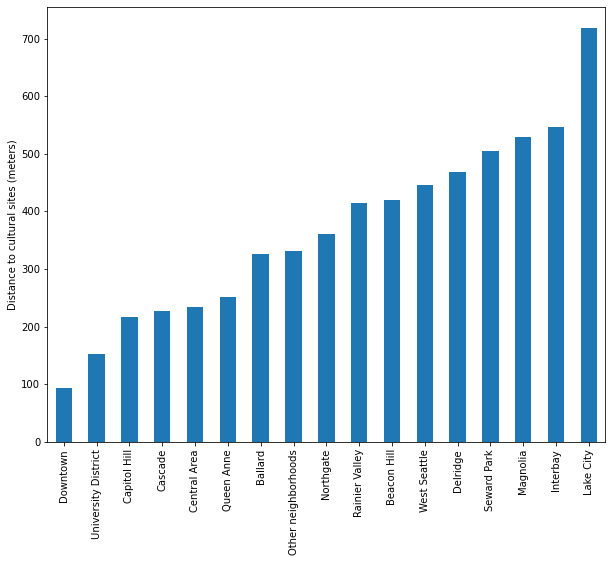

In [41]:
# Average distance to cultural sites by neighbourhoob
print(gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['distance'].mean().sort_values()[:3])
gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['distance'].mean().sort_values().plot.bar(figsize=(10,8), xlabel='', ylabel='Distance to cultural sites (meters)');

## Does the variable 'distance' help to create a more accurate predictive model?

In [42]:
# Define variables of interest based on the data exploration
variables_of_interest = [
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'number_of_reviews',
    'review_scores_rating',
    'cancellation_policy',
    'reviews_per_month',
    'distance',
    'price_cleansed']

# Subset dataset using the variables of interest
df = gpd_airbnb_cultural[variables_of_interest].copy()

In [43]:
# Function to prepare the dataset
def prepare_data(df, y_column, include_distance=False):
    '''
    INPUT
    df - pandas dataframe 
    y_column - response variable
    include_distance - Bool
    
    OUTPUT
    X - variables to predict
    y - response vector
    '''

    # Response vector
    y = df[[y_column]]

    # Drop response columns
    if include_distance == False:
        df = df.drop([y_column, 'distance'], axis=1)
    else:
        df = df.drop(y_column, axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each variable add dummy one and drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    # variables dataframe
    X = df
    
    return X, y


In [44]:
# Function to create a linear model and evaluate its accuracy
def seattle_model(df, y_column, include_distance=False, test_size=0.3, random_state=1010):

    # Prepare the data
    X, y = prepare_data(df, y_column, include_distance)
    
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)

    # Create and fit the model
    lm_model = make_pipeline(StandardScaler(), LinearRegression())
    lm_model.fit(X_train, y_train)

    # Model prediction
    y_test_preds = lm_model.predict(X_test)
    # y_train_preds = lm_model.predict(X_train)

    # Print test r2 scores
    print('r2 score:', r2_score(y_test, y_test_preds))

    # Return model coefficient weights
    coef_weights = pd.DataFrame()
    coef_weights['Coefficient'] = lm_model.feature_names_in_
    coef_weights['Val'] = lm_model['linearregression'].coef_.T
    coef_weights['Abs_Val'] = np.abs(lm_model['linearregression'].coef_.T)
    coef_weights.set_index('Coefficient', inplace=True)
    return coef_weights

In [47]:
# Compare r2 scores
print("Linear model without the geospatial variable 'distance'")
coef_no_geospatial = seattle_model(df, 'price_cleansed', include_distance=False)
print("Linear model with the geospatial variable 'distance'")
coef_geospatial = seattle_model(df, 'price_cleansed', include_distance=True)

Linear model without the geospatial variable 'distance'
r2 score: 0.5291323860268592
Linear model with the geospatial variable 'distance'
r2 score: 0.5334407326167638


## Which are the most influential variables for predicting price per night?

                          Abs_Val
Coefficient                      
bedrooms                25.887128
accommodates            24.230653
room_type_Private room  19.001645
bathrooms               18.608346
room_type_Shared room   12.571275
property_type_Boat       8.167986
availability_60          7.590217
reviews_per_month        6.234716
distance                 6.130939
review_scores_rating     5.114357


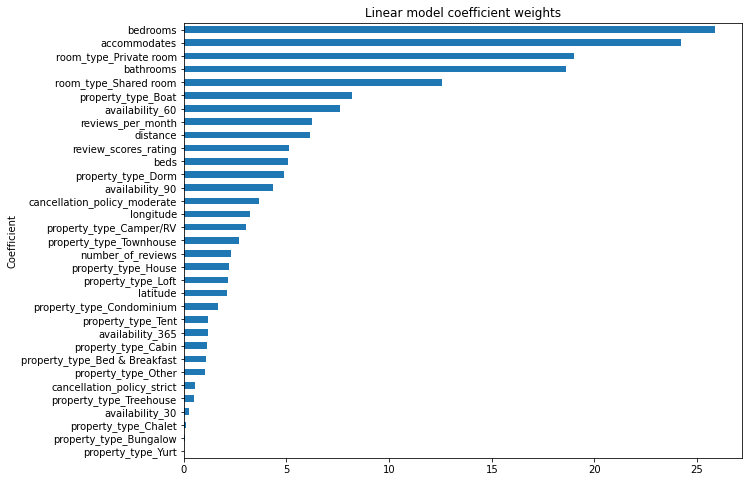

In [46]:
# Visualization of coefficient weights
print(coef_geospatial[['Abs_Val']].sort_values('Abs_Val', ascending=False)[:10])
coef_geospatial[['Abs_Val']].sort_values('Abs_Val').plot.barh(title='Linear model coefficient weights', figsize=(10,8), legend=False);